<a href="https://www.kaggle.com/code/sudhanshu727/scene-grounding-project?scriptVersionId=256158583" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Scene Grounding in Dense Visual Environments

**Objective:** To locate and highlight a specific action or object within a dense image based on a natural language description.

**Methodology:** This notebook implements a baseline solution using a pre-trained CLIP model (ViT-B/32) to generate embeddings for both the image and the text query. A grid-based approach is used for region proposals, and the region with the highest cosine similarity to the text query is selected as the grounded region.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Setup and Installation

This section installs the necessary libraries for the project. We will be using `torch`, `torchvision`, and `ftfy` for the CLIP model, `transformers` for the tokenizer, and `matplotlib` for visualization.

In [2]:
pip install "numpy==1.26.4"

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# Step 1: Uninstall all existing versions of OpenCV to remove conflicts
!pip uninstall -y opencv-python opencv-contrib-python

# Step 2: Install only the version that includes the extra modules
!pip install opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cmd7fv95
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cmd7fv95
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
import clip 
from PIL import Image
import requests


## 2. Model Loading

Here, we load the pre-trained CLIP model (ViT-B/32) and its associated preprocessor. The `eval()` method sets the model to evaluation mode.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the ResNet-50 model ("RN50") and its image preprocessor
model, preprocess = clip.load("RN50", device=device)

print(f"CLIP RN50 model loaded successfully on device: {device}")

100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 127MiB/s]


CLIP RN50 model loaded successfully on device: cuda


## 3. Helper Functions

### 3.1. Region Proposal Generation

The `generate_selective_search_proposals` function uses a simple grid-based approach to generate candidate bounding boxes. This is a fast and effective method for creating region proposals for our baseline model.

In [6]:

import numpy as np
import cv2 # Make sure you have run: pip install opencv-contrib-python

def generate_selective_search_proposals(image):
    """
    Generates region proposals using Selective Search.
    The input 'image' should be the original PIL Image object.
    """
    # Convert the PIL image to a NumPy array for OpenCV
    img_np = np.array(image)
    
    # Selective search works on 3-channel images.
    # If the image has an alpha channel, convert it.
    if img_np.shape[2] == 4:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGBA2RGB)
        
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img_np)
    ss.switchToSelectiveSearchFast() # Use fast mode for speed
    
    rects = ss.process()
    proposals = []
    for (x, y, w, h) in rects:
        # Convert (x, y, width, height) to (x1, y1, x2, y2)
        proposals.append([x, y, x + w, y + h])
        
    # Return the top 1000 proposals for a balance of coverage and speed
    return proposals[:1000]

@torch.no_grad()
def ground_query(image, query, model, preprocess, device):
    """
    Finds the image region that best matches the text query using Selective Search.
    
    Args:
        image (PIL.Image): The input image.
        query (str): The natural language text query.
        model: The loaded CLIP model.
        preprocess: The CLIP image preprocessor.
        device (str): "cuda" or "cpu".
    
    Returns:
        tuple: A tuple containing the best bounding box ([x1, y1, x2, y2]) and its score.
    """
    
    # 1. Generate proposals using Selective Search
    proposals = generate_selective_search_proposals(image)
    if not proposals:
        print("Selective Search returned no proposals.")
        return None, 0
    print(f"Generated {len(proposals)} candidate regions with Selective Search.")
    
    # 2. Prepare image crops and preprocess them
    image_crops = [preprocess(image.crop(box)).unsqueeze(0) for box in proposals]
    image_input = torch.cat(image_crops).to(device)
    
    # 3. Tokenize and prepare the text query
    text_input = clip.tokenize([query]).to(device)
    
    # 4. Get embeddings
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_input)
    
    # 5. Normalize features and calculate cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    similarities = (100.0 * image_features @ text_features.T).squeeze()
    
    # 6. Find the best match
    best_proposal_idx = similarities.argmax()
    best_proposal = proposals[best_proposal_idx]
    best_score = similarities[best_proposal_idx].item()
    
    return best_proposal, best_score

### 3.2. Scene Grounding

The `get_grounded_bbox_clip` function is the core of our project. It takes an image and a text query as input and returns the bounding box of the region with the highest similarity to the query. It works by:
1. Generating region proposals using the `generate_selective_search_proposals` function.
2. For each proposal, it crops the region, gets the CLIP image embedding.
3. It also gets the CLIP text embedding for the input query.
4. It calculates the cosine similarity between the image and text embeddings.
5. The bounding box with the highest similarity score is returned.

In [7]:
@torch.no_grad()
def get_grounded_bbox_clip(image, query):
    """
    Finds the image region that best matches the text query using CLIP and Selective Search.
    """
    # 1. Generate proposals using Selective Search
    proposals = generate_selective_search_proposals(image)
    if not proposals:
        print("Selective Search returned no proposals.")
        return None, 0
    print(f"Generated {len(proposals)} candidate regions with Selective Search.")
    
    # 2. Prepare image crops from proposals and preprocess them for CLIP
    image_crops = [preprocess(image.crop(box)).unsqueeze(0) for box in proposals]
    image_input = torch.cat(image_crops).to(device)
    
    # 3. Prepare the text query for CLIP
    text_input = clip.tokenize([query]).to(device)
    
    # 4. Get embeddings from the CLIP model
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_input)
    
    # 5. Normalize features and calculate cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    similarities = (100.0 * image_features @ text_features.T).squeeze()
    
    # 6. Find the proposal with the highest similarity score
    best_proposal_idx = similarities.argmax()
    best_proposal = proposals[best_proposal_idx]
    best_score = similarities[best_proposal_idx].item()
    
    return best_proposal, best_score

print("Core logic function is defined.")

Core logic function is defined.


## 4. Demonstration

This section demonstrates the functionality of our scene grounding system. We use a sample image and a text query to showcase the model's ability to locate the described region. The final output is the image with the grounded region highlighted by a bounding box.

Loading image and preparing query...
Image Loaded

Running the model to find the described region...
Generated 1000 candidate regions with Selective Search.
Grounding complete. Found box with score: 19.20
Visualizing the output...


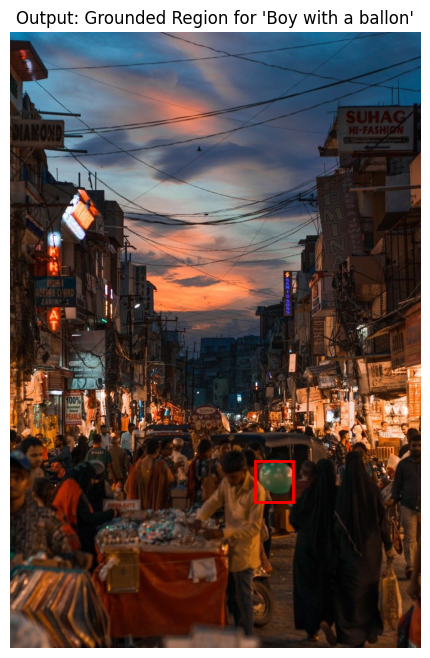

In [8]:
# ENTER INPUT IMAGE LINK AND THE TEXT QUERY HERE, THEN EXECUTE THE CELL

image_url = "https://i.pinimg.com/1200x/95/cd/57/95cd5794f71966bf3c0e1e341802d525.jpg" 
text_query = "Boy with a ballon"

print("Loading image and preparing query...")
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
print("Image Loaded")


print("\nRunning the model to find the described region...")
predicted_box, score = get_grounded_bbox_clip(image, text_query)
print(f"Grounding complete. Found box with score: {score:.2f}")



print("Visualizing the output...")


import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)

if predicted_box:
    # Create a Rectangle patch for the predicted box
    rect = patches.Rectangle(
        (predicted_box[0], predicted_box[1]),      # (x,y) bottom-left corner
        predicted_box[2] - predicted_box[0],    # width
        predicted_box[3] - predicted_box[1],    # height
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    
    ax.add_patch(rect)

ax.set_title(f"Output: Grounded Region for '{text_query}'")
ax.axis("off")

plt.show()

## 5. Submission Details

### 5.1. Demo Video

https://drive.google.com/file/d/1HboIqu4KgYfYeIhhDPoQF9Z_y9svP9yl/view?usp=sharing

### 5.2. How to Run

To run this notebook, simply execute all the cells in order. The final output will be an image with the grounded region highlighted.